

# Ensemble Methods and Skewed Data

## Aditya Patel

We are going explore two ensemble methods:

  - AdaBoost, and
  - Random Forests
  
Along with applying different KPIs (key performance indicators) that are more appropriate to highly skewed data sets. 

The dataset contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 237 frauds out of 142,167 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.17% of all transactions.

It contains only numerical input variables which are the result of a [PCA transformation](https://en.wikipedia.org/wiki/Principal_component_analysis). Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount in Euros. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_roc_curve

# This is the credit card data provided, we'll use sklearn methods to do cross validation
# to estimate error
df_cc = pd.read_csv('cc.csv')

## Q1 Parition the data for cross validation



We know this is a _super_ skewed data set, so we worry about our target class being underrepresented in a random k-fold selection. With this in mind, we use a [stratifed k-fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html), since it will preserve our class balance in our experiements. Use $k=3$, . Instantiate an instance of the `StratifiedKFold` class, and use the generator `split` to populate the test and train dictonaries:
   - `d_train_df_X` : key is the fold number, value is the attribute training dataframe at that fold
   - `d_test_df_X`  : key is the fold number, value is the attribute test dataframe at that fold
   - `d_train_s_y`  : key is the fold number, value is the target training series at that fold
   - `d_train_s_y`  : key is the fold number, value is the target test series at that fold

In [2]:
df_X = df_cc.drop(columns=['Class'])
s_y = df_cc['Class']

In [3]:
skf = StratifiedKFold(n_splits=3,shuffle=True,random_state=23)

In [4]:
d_train_df_X = dict()
d_test_df_X = dict()
d_train_s_y = dict()
d_test_s_y = dict()


fold = 1
for train_index, test_index in skf.split(df_X, s_y):
    X_train, X_test = df_X.iloc[train_index], df_X.iloc[test_index]
    y_train, y_test = s_y.iloc[train_index], s_y.iloc[test_index]
    d_train_df_X[fold] = X_train
    d_test_df_X[fold] = X_test
    d_train_s_y[fold] = y_train
    d_test_s_y[fold] = y_test
    fold += 1

In [5]:
# Look at the test data and verify that the target training is equally distributed as possible
for key in d_test_s_y.keys():
    print(d_test_s_y[key].value_counts())

0    47389
1       79
Name: Class, dtype: int64
0    47389
1       79
Name: Class, dtype: int64
0    47389
1       79
Name: Class, dtype: int64


## AdaBoost

# Testing the Performance of AdaBoost


In [6]:
k = 3
acc_ab = np.zeros(k)
tpr_ab = np.zeros(k)
ppv_ab = np.zeros(k)
fpr_ab = np.zeros(k)

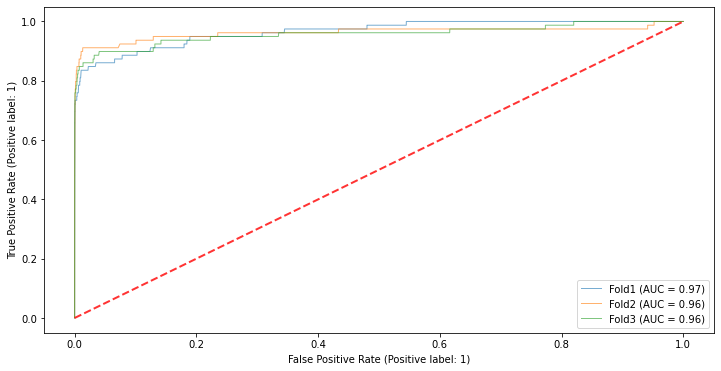

In [22]:

fig, ax = plt.subplots(figsize=(12,6))
for key in d_train_df_X.keys():
    ada = AdaBoostClassifier(n_estimators=25, random_state=23)
    ada.fit(d_train_df_X[key], d_train_s_y[key])
    predict = ada.predict(d_test_df_X[key])
    correct = np.sum(predict == d_test_s_y[key].to_numpy())
    acc = (correct/d_test_s_y[key].size)
    acc_ab = np.append(acc_ab, acc)
    
    tp = (np.sum(np.logical_and(predict == 1,d_test_s_y[key].to_numpy() == 1)))
    fp = (np.sum(np.logical_and(predict == 1, d_test_s_y[key].to_numpy() == 0)))
    tn = (np.sum(np.logical_and(predict == 0, d_test_s_y[key].to_numpy() == 0)))
    fn = (np.sum(np.logical_and(predict == 0, d_test_s_y[key].to_numpy() == 1)))
    
    tpr = tp/(tp + fn)
    tpr_ab = np.append(tpr_ab, tpr)
    
    ppv = tp/(tp + fp)
    ppv_ab = np.append(ppv_ab, ppv)
    
    fpr = fp/(fp+tn)
    fpr_ab = np.append(fpr_ab, fpr)
    
    if key == 3:
        y_hat_ab = predict
    boom = plot_roc_curve(ada, d_test_df_X[key], d_test_s_y[key], name = ("Fold" + str(key)),alpha = 0.6,lw = 1, ax = ax) 

    
ax.plot([0,1],[0,1],linestyle = '--', lw = 2, color = 'r', label = "Chance", alpha = 0.8)
plt.show()
    

        

# Since we appended values onto the arrays the first 3 elements are 0 so we are removing them from the array
    
for i in range(3):
    tpr_ab = np.delete(tpr_ab, 0)
    ppv_ab = np.delete(ppv_ab, 0)
    fpr_ab = np.delete(fpr_ab,0)
    acc_ab = np.delete(acc_ab, 0)


In [23]:
print('The min, mean, and max TPR are: {:.2f}, {:.2f}, and {:.2f}'.format(tpr_ab.min(), tpr_ab.mean(), tpr_ab.max()))
print('The min, mean, and max PPV are: {:.2f}, {:.2f}, and {:.2f}'.format(ppv_ab.min(), ppv_ab.mean(), ppv_ab.max()))
print('The min, mean, and max ACC are: {:.2f}, {:.2f}, and {:.2f}'.format(acc_ab.min(), acc_ab.mean(), acc_ab.max()))

The min, mean, and max TPR are: 0.62, 0.65, and 0.71
The min, mean, and max PPV are: 0.75, 0.79, and 0.82
The min, mean, and max ACC are: 1.00, 1.00, and 1.00


##  Testing the Performance of Random Forests


We will build complete trees, with no pruning.  That means every leaf in the tree will be completelely pure, and if you exam an individual Decision Tree it would be overtrained to our training set.  While building the decision trees, at every internal node, we select $p$ attributes at random, and then find the best split that minimizes impurtity.  The value, $p$, is a hyperparamter of the Random Forest and corresponds to the `max_features` parameter in the Random Forest Class. 


In [24]:
k = 3
acc_rf = np.zeros(k)
tpr_rf = np.zeros(k)
ppv_rf = np.zeros(k)
fpr_rf = np.zeros(k)

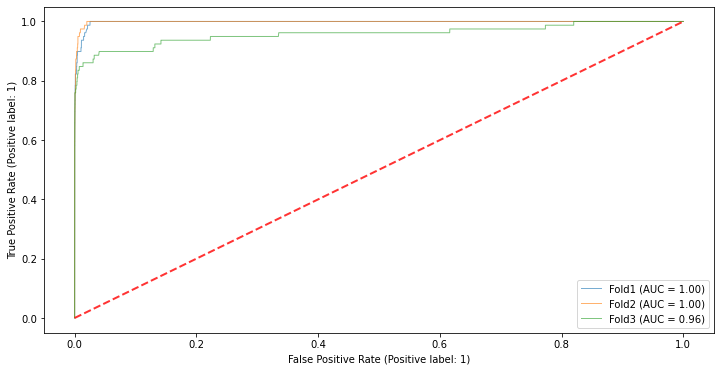

In [25]:
fig, ax = plt.subplots(figsize = (12,6))

for key in d_train_df_X.keys():
    rfc = RandomForestClassifier(criterion="entropy", max_features="sqrt", random_state=23)
    rfc.fit(d_train_df_X[key], d_train_s_y[key])
    predict = rfc.predict(d_test_df_X[key])
    correct = np.sum(predict == d_test_s_y[key].to_numpy())
    acc = (correct/d_test_s_y[key].size)
    acc = (correct/d_test_s_y[key].size)
    acc_rf = np.append(acc_rf, acc)
    
    tp = (np.sum(np.logical_and(predict == 1,d_test_s_y[key].to_numpy() == 1)))
    fp = (np.sum(np.logical_and(predict == 1, d_test_s_y[key].to_numpy() == 0)))
    tn = (np.sum(np.logical_and(predict == 0, d_test_s_y[key].to_numpy() == 0)))
    fn = (np.sum(np.logical_and(predict == 0, d_test_s_y[key].to_numpy() == 1)))
    
    tpr = tp/(tp + fn)
    tpr_rf = np.append(tpr_rf, tpr)
    
    ppv = tp/(tp + fp)
    ppv_rf = np.append(ppv_rf, ppv)
    
    fpr = fp/(fp+tn)
    fpr_rf = np.append(fpr_rf, fpr)
    
    if key == 3:
        y_hat_rf = predict

    boom = plot_roc_curve(ada, d_test_df_X[key], d_test_s_y[key], name = ("Fold" + str(key)),alpha = 0.6,lw = 1, ax = ax) 

ax.plot([0,1],[0,1],linestyle = '--', lw = 2, color = 'r', label = "Chance", alpha = 0.8)
plt.show()
    

# Since we appended values onto the arrays the first 3 elements are 0 so we are removing them from the array
    
for i in range(3):
    tpr_rf = np.delete(tpr_rf, 0)
    ppv_rf = np.delete(ppv_rf, 0)
    fpr_rf = np.delete(fpr_rf,0)
    acc_rf = np.delete(acc_rf, 0)
    

In [10]:
print('The min, mean, and max TPR are: {:.2f}, {:.2f}, and {:.2f}'.format(tpr_rf.min(), tpr_rf.mean(), tpr_rf.max()))
print('The min, mean, and max PPV are: {:.2f}, {:.2f}, and {:.2f}'.format(ppv_rf.min(), ppv_rf.mean(), ppv_rf.max()))
print('The min, mean, and max ACC are: {:.2f}, {:.2f}, and {:.2f}'.format(acc_rf.min(), acc_rf.mean(), acc_rf.max()))

The min, mean, and max TPR are: 0.75, 0.78, and 0.80
The min, mean, and max PPV are: 0.92, 0.93, and 0.95
The min, mean, and max ACC are: 1.00, 1.00, and 1.00


# Calculating the Cost of Fraud 

For the purpose of this project, lets assume:

For every fraudulent transaction that is not predicted as fraudulent the bank looses twice that much money.  So, a fradulent charge for €10 is undectected, it costs the bank €20.  Also, if a charge is predicted as fradulent, but wasn't, it costs the bank a flat fee of €3 in customer service support to communicate with the customer, and mark the possible fraud as a normal transaction. 



In [12]:
amount0 =  0
amount1 = 0
for i in range(len(d_test_s_y[3])):
    if d_test_s_y[3].iloc[i] == 1 and y_hat_ab[i] == 0 :
        amount0 += float((d_test_df_X[3].iloc[i]["Amount"])) * 2
    if y_hat_ab[i] == 1 and d_test_s_y[3].iloc[i] == 0:
        amount0 += 3

for i in range(len(d_test_s_y[3])):
    if d_test_s_y[3].iloc[i] == 1 and y_hat_rf[i] == 0 :
        amount1 += float((d_test_df_X[3].iloc[i]["Amount"])) * 2
    if y_hat_rf[i] == 1 and d_test_s_y[3].iloc[i] == 0:
        amount1 += 3

        
        
print("Total Amount lost due to inconsistencies with AdaBoost:",amount0)
print("Total Amount lost due to inconsistencies with Random Forests:",amount1)

Total Amount lost due to inconsistencies with AdaBoost: 8538.32
Total Amount lost due to inconsistencies with Random Forests: 4363.38


### Mr Bank man will save more money, if we deploy the Random Forests algorithm! 